<a href="https://colab.research.google.com/github/Chait314/reasoning/blob/main/Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import gymnasium as gym
import numpy as np;
import math;
import random;
import matplotlib.pyplot as plt;
import seaborn as sns;

In [8]:
class BlackJack:
  def __init__(self):
      self.action_space = [0,1];
      self.suits = ['H', 'D', 'C', 'S']  # Hearts, Diamonds, Clubs, Spades
      self.values = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']
      self.used_cards = [];
      self.reset();

  def reset(self):
      self.deck = [[suit, value] for suit in self.suits for value in self.values];
      self.player_hand = [self.get_hand(),self.get_hand()];
      self.dealer_hand = [self.get_hand(),self.get_hand()];
      self.used_cards = [];
      self.done = False;
      return self.get_state();

  def get_hand(self):
      val = np.random.randint(52);
      card = self.deck[val];


      while card in self.used_cards:
          val = np.random.randint(52);
          card = self.deck[val];
         # print("card");
      self.used_cards.append(card);
      return card;

  def get_value(self,card):
      cardi = card[1];

      if cardi == 'J' or cardi == 'K' or cardi == 'Q':
          return 10;
      if cardi == 'A':
          return 11;
      else:
          return int(cardi);

  def get_total(self, hand):
      total = sum([self.get_value(card) for card in hand]);

      for card in hand:
          if card[1] == 'A' and total > 21:
              total -= 10;
      return total;

  def get_state(self):
      player_total = self.get_total(self.player_hand);
      dealer_showing = self.get_value(self.dealer_hand[0]);

      usable_ace = any(card[1] == 'A' for card in self.player_hand) and (player_total <= 21)
      if usable_ace == False:
          usA = 0;
      else:
          usA = 1;


      return (player_total, dealer_showing, usA);


  def step(self, action):
      if action == 0:
          card = self.get_hand()
          self.player_hand.append(card)
          if self.get_total(self.player_hand) > 21:
              self.done = True
              return self.get_state(), -1, self.done, {};
          else:
              return self.get_state(), 0, self.done, {};

      else:
          self.done = True;

          player_total = self.get_total(self.player_hand);

          while True:
              dealer_total = self.get_total(self.dealer_hand);
              if dealer_total >= 17:
                  break;
              card = self.get_hand();
              self.dealer_hand.append(card);
              dealer_total = self.get_total(self.dealer_hand);

          reward = 0;
          if player_total > 21:
              reward = -1;
          elif dealer_total > 21:
              reward = 1;
          elif player_total > dealer_total:
              reward = 1;
          elif player_total < dealer_total:
              reward = -1;
          else:
              reward = 0;

          #print(reward);

          return self.get_state(), reward, self.done, {};










In [35]:
class DoubleQLearning:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env;
        self.alpha = 0.1
        self.gamma = 0.9
        self.epsilon = 0.1
        self.decay = 0.998
        self.minepsilon = 0.001


        self.Q1 = np.random.uniform(-0.1,0.1,size = (32,12,2,2));
        self.Q2 = np.random.uniform(-0.1,0.1,size = (32,12,2,2));


    def choose_action(self, state):
        player_total, dealer_showing, usable_ace = state

        player_total = max(4, min(31, player_total))
        dealer_showing = max(1, min(10, dealer_showing))
        usable_ace = int(usable_ace)

        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.action_space)

        q_values = self.Q1[player_total, dealer_showing, usable_ace] + \
                   self.Q2[player_total, dealer_showing, usable_ace]

        #print(np.argmax(q_values));

        return np.argmax(q_values)
    def update(self, state, reward, action, next_state, done):
        if np.random.rand() < 0.5:
            best_action = np.argmax(self.Q1[next_state[0], next_state[1], next_state[2]]);
            target = reward + (self.gamma*(self.Q2[next_state[0], next_state[1], next_state[2],best_action])*(1 if not done else 0));
            self.Q1[state[0], state[1], state[2], action] += self.alpha*(target - self.Q1[state[0], state[1], state[2], action]);
        else:
            best_action = np.argmax(self.Q2[next_state[0], next_state[1], next_state[2]]);
            target = reward + (self.gamma*(self.Q1[next_state[0], next_state[1], next_state[2],best_action])*(1 if not done else 0));
            self.Q2[state[0], state[1], state[2], action] += self.alpha * (target - self.Q2[state[0], state[1], state[2], action]);

        self.epsilon = max(self.minepsilon, self.epsilon*self.decay);

    def exploit(self, state):
        player_total, dealer_showing, usable_ace = state

        player_total = max(4, min(31, player_total))
        dealer_showing = max(1, min(10, dealer_showing))
        usable_ace = int(usable_ace)

        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.action_space)

        q_values = self.Q1[player_total, dealer_showing, usable_ace] + \
                   self.Q2[player_total, dealer_showing, usable_ace];

        return np.argmax(q_values)

    def train(self, num_eps):
        for episodes in range(num_eps):
            state = self.env.reset();
            done = False;
            episode_reward = 0;
            #print(episodes);
            while not done:
                action = self.choose_action(state);
                #print(state);
                next_state, reward, done, _ = self.env.step(action);
                self.update(state, reward, action, next_state, done);
                state = next_state;
                episode_reward += reward;

    def test(self, num_eps):
        wins = 0;
        for episodes in range(num_eps):
            state = self.env.reset();
            done = False;
            episode_reward = 0;


            while not done:
                action = self.exploit(state);
                next_state, reward, done, _ = self.env.step(action);
                state = next_state;
                episode_reward += reward;
                #print(done,reward);
                if done and reward > 0:
                    wins += 1;
        print(f"win percentage: {100*(wins/num_eps)}%");

    def printQ(self):
        print(self.Q1);
        print(self.Q2);

    def plot_policy(self, usable_ace=0):

        policy_grid = np.zeros((18, 10))

        for player_sum in range(4, 22):
            for dealer_card in range(1, 11):

                q_sum = self.Q1[player_sum, dealer_card, usable_ace] + \
                        self.Q2[player_sum, dealer_card, usable_ace]
                best_action = np.argmax(q_sum)
                policy_grid[player_sum-4, dealer_card-1] = best_action

        plt.figure(figsize=(10, 8))
        sns.heatmap(policy_grid,
                   annot=True,
                   cmap=['red', 'green'],
                   cbar=False,
                   yticklabels=range(4, 22),
                   xticklabels=['A'] + list(range(2, 11)),
                   linewidths=0.5)

        legend_labels = ['Hit (0)', 'stand (1)']
        color_patches = [plt.Rectangle((0,0),1,1, fc='red'),
        plt.Rectangle((0,0),1,1, fc='green')]
        plt.legend(color_patches, legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', title='Action')

        plt.title(f"Learned Blackjack Policy ({'With' if usable_ace else 'No'} Usable Ace)")
        plt.xlabel("Dealer Upcard")
        plt.ylabel("Player Hand Total")
        plt.tight_layout()
        plt.show()

    def plot_value_function(self, usable_ace=0):
        value_grid = np.zeros((18, 10))

        for player_sum in range(4, 22):
            for dealer_card in range(1, 11):
                q_sum = self.Q1[player_sum, dealer_card, usable_ace] + \
                        self.Q2[player_sum, dealer_card, usable_ace]
                best_action = np.argmax(q_sum)
                value = (self.Q1[player_sum, dealer_card, usable_ace, best_action] +
                         self.Q2[player_sum, dealer_card, usable_ace, best_action]) / 2
                value_grid[player_sum-4, dealer_card-1] = value

        plt.figure(figsize=(10, 8))
        sns.heatmap(value_grid,
                   annot=True,
                   fmt=".2f",
                   cmap="viridis",
                   yticklabels=range(4, 22),
                   xticklabels=['A'] + list(range(2, 11)))

        plt.title(f"State Values ({'With' if usable_ace else 'No'} Usable Ace)")
        plt.xlabel("Dealer Showing")
        plt.ylabel("Player Total")
        plt.show()


In [36]:
env = BlackJack();
agent = DoubleQLearning(env);


In [37]:
agent.train(100000);

In [40]:
agent.test(20000);

win percentage: 43.1%


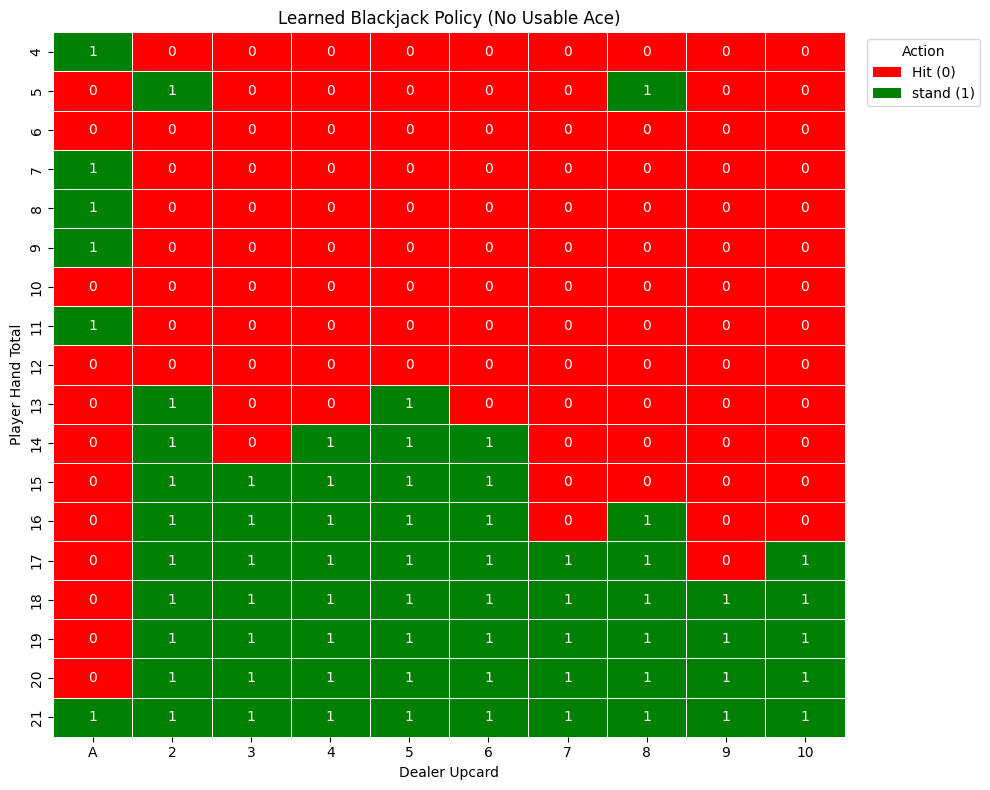

In [41]:
agent.plot_policy();

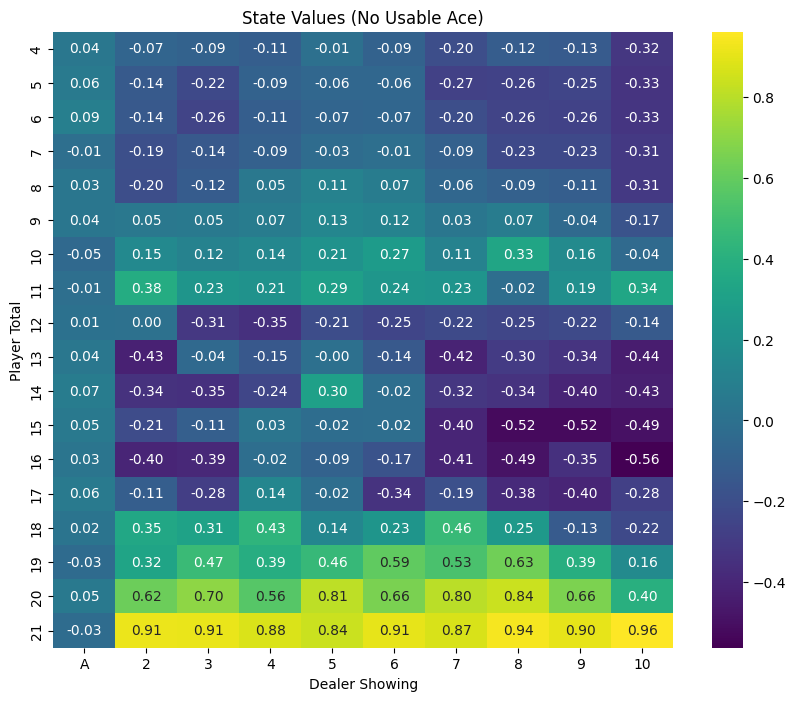

In [14]:
agent.plot_value_function();